In [667]:
import pypsa
import pandas as pd
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import yaml
import matplotlib.pyplot as plt

In [668]:
matplotlibrc_fn = "../pypsa-eur/matplotlibrc"
config_fn = "../../config/config.yaml"

plt.style.use(["bmh", matplotlibrc_fn])

with open(config_fn, "r") as f:
    config = yaml.safe_load(f)

tech_colors = config["plotting"]["tech_colors"]


In [669]:
fn = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc"

In [670]:
ni = pypsa.Network(fn)

INFO:pypsa.io:Imported network elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [671]:
NICE_NAMES = {
    "import pipeline-h2": "hydrogen",
    "import shipping-lh2": "hydrogen (ship)",
    "import shipping-ftfuel": "Fischer-Tropsch",
    "import shipping-meoh": "methanol",
    "import shipping-lch4": "methane",
    "import shipping-lnh3": "ammonia",
    "import shipping-steel": "steel",
}

min_import_costs = pd.concat([
    ni.generators.filter(like="import", axis=0).groupby("carrier").marginal_cost.describe(),
    ni.links.filter(like="import", axis=0).groupby("carrier").marginal_cost.describe(),
])
min_import_costs = min_import_costs[["min", "max"]].rename(index=NICE_NAMES).drop("import hvdc-to-elec")
min_import_costs

,min,max
carrier,,
hydrogen,54.205180,65.595563
hydrogen (ship),78.520739,84.734559
ammonia,82.618648,82.618648
steel,471.751936,471.751936
Fischer-Tropsch,103.497777,103.497777
methane,97.910557,98.682240
methanol,100.597813,100.597813


In [672]:
# fn = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp+H2_2050.nc"
fn = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc"
# fn = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/results/20231025-zecm/postnetworks/elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5_2050.nc"

scenario_name = "allimport"

In [673]:
n = pypsa.Network(fn)

INFO:pypsa.io:Imported network elec_s_110_lvopt__Co2L0-2190SEG-T-H-B-I-S-A-onwind+p0.5-imp_2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [674]:
ac_prices = n.buses_t.marginal_price.loc[:, (n.buses.carrier == "AC") & (n.buses.index.str.len() != 2)]
h2_prices = n.buses_t.marginal_price.loc[:, n.buses.carrier == "H2"].rename(columns=n.buses.location)
heat_prices = n.buses_t.marginal_price.loc[:, n.buses.carrier == "urban central heat"].rename(columns=n.buses.location)
nh3_prices = n.buses_t.marginal_price["EU NH3"]
oil_prices = n.buses_t.marginal_price["EU oil"]
steel_prices = n.buses_t.marginal_price["EU steel"]
meoh_prices = n.buses_t.marginal_price["EU methanol"]
co2_prices = n.buses_t.marginal_price["co2 stored"]
co2_tax = n.buses_t.marginal_price["co2 atmosphere"]

## Breakdown electrolyser market value

In [675]:
mapper = n.links.bus1.map(n.buses.location)
carrier = "H2 Electrolysis"
threshold = 1
weights = n.snapshot_weightings.generators

In [676]:
electrolysers = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(index=mapper)

In [677]:

electrolysers_capex = electrolysers.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [678]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
electrolysers_ac = n.links_t.p0.loc[:, sel].rename(columns=mapper)
electrolysers_h2 = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
electrolysers_heat = -n.links_t.p2.loc[:, sel].rename(columns=mapper)

In [679]:
electrolysers_h2_output = weights @ electrolysers_h2

In [680]:
## start time series

In [681]:
electrolysers_ac_cost_t = (ac_prices[electrolysers.index] * electrolysers_ac) / electrolysers_h2
electrolysers_heat_revenue_t = (heat_prices[electrolysers.index] * electrolysers_heat) / electrolysers_h2
electrolysers_capex_t = (electrolysers_capex * electrolysers_h2.mul(weights, axis=0).div(electrolysers_h2_output)) / electrolysers_h2_output

In [682]:
electrolysers_cost_t = (electrolysers_ac_cost_t + electrolysers_heat_revenue_t + electrolysers_capex_t)

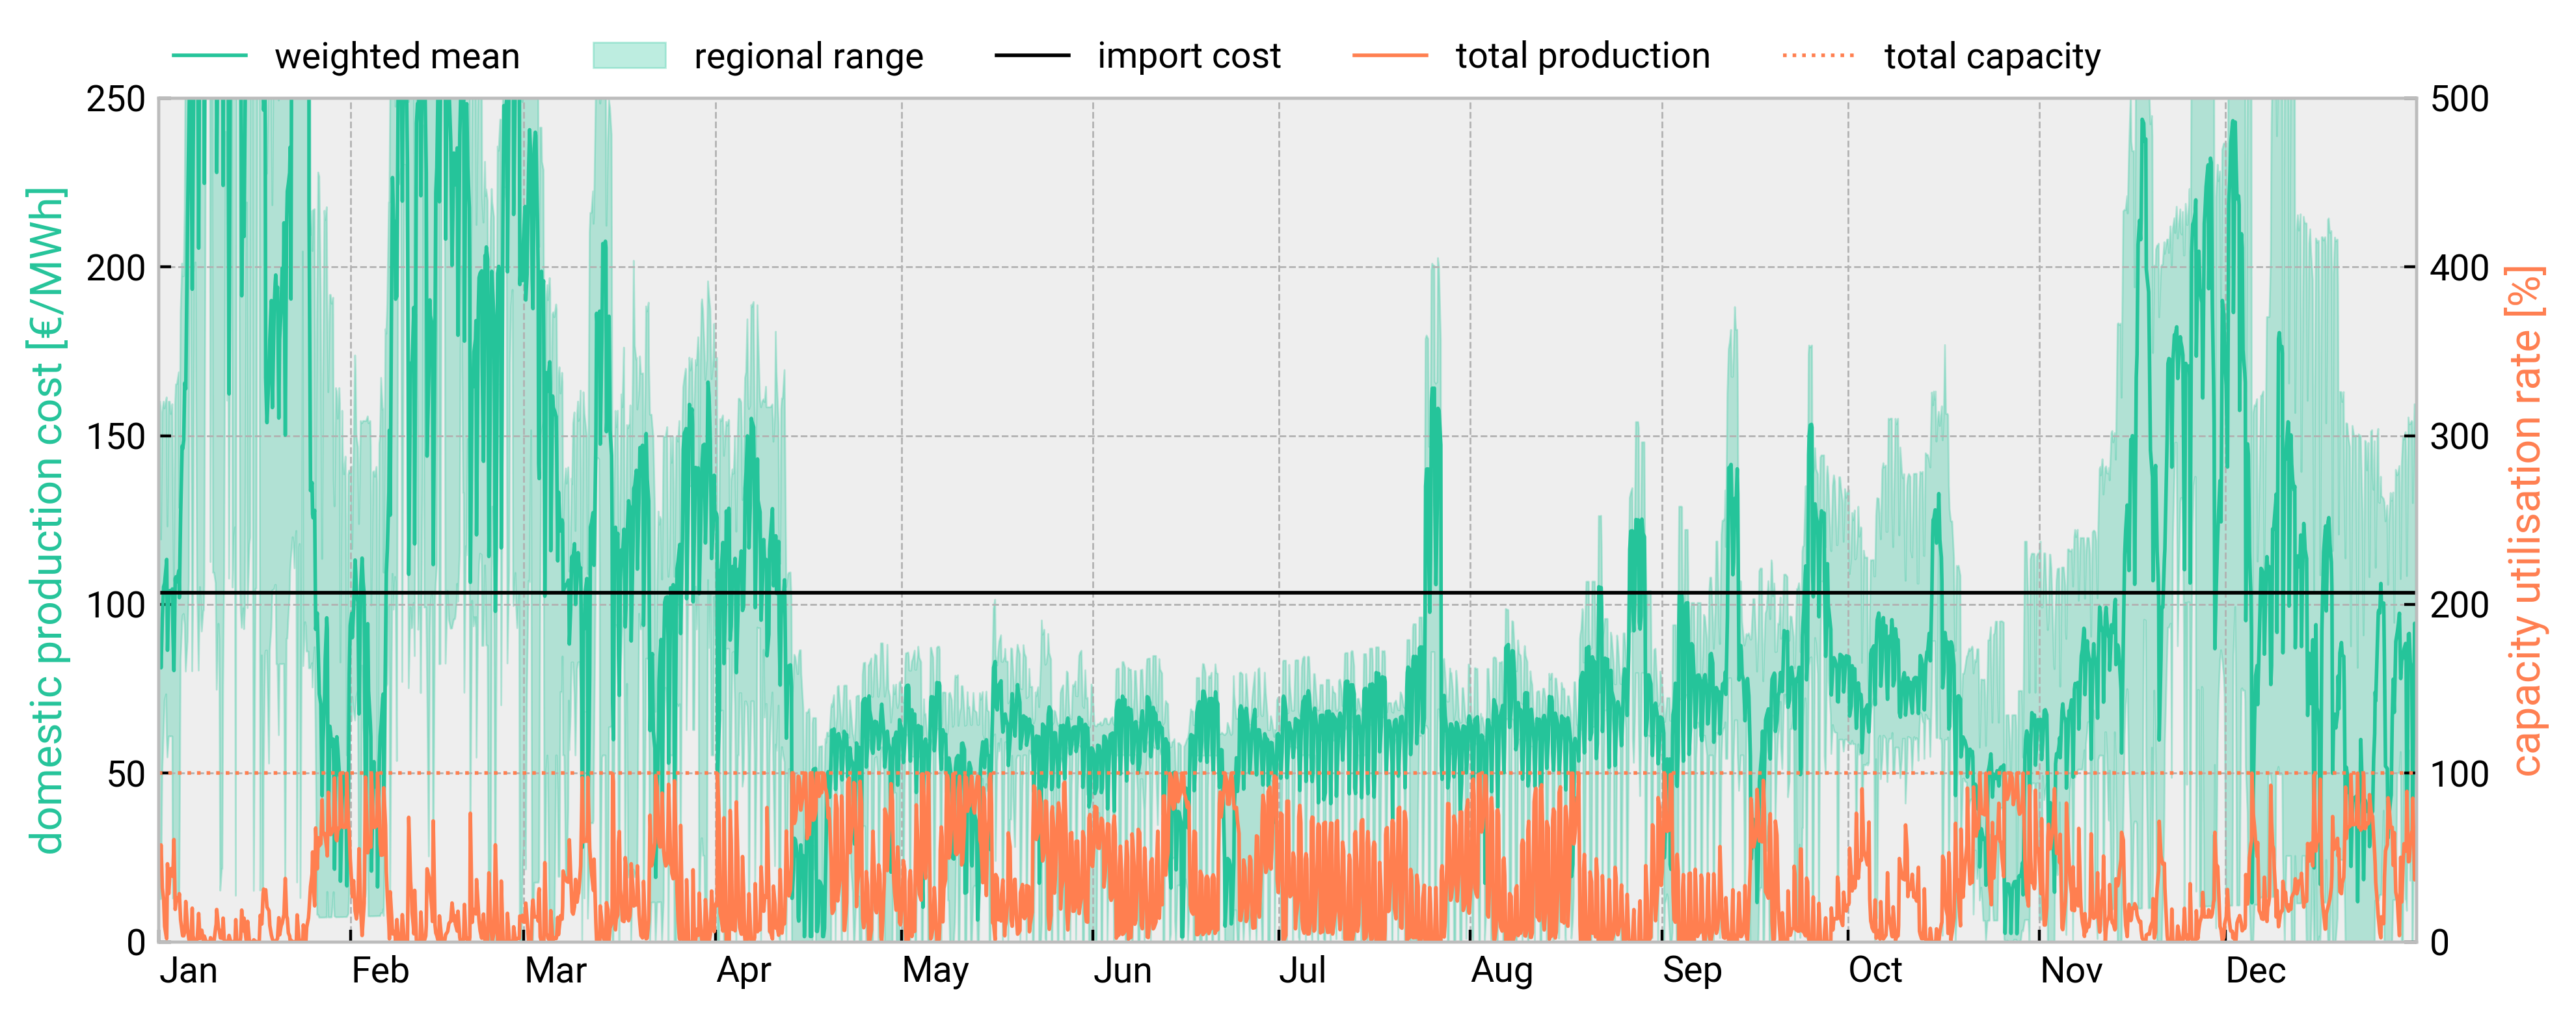

In [683]:
mean_values = (electrolysers_cost_t * electrolysers_h2_output).sum(axis=1) / electrolysers_h2_output.sum()
min_values = electrolysers_cost_t.min(axis=1)
max_values = electrolysers_cost_t.max(axis=1)

fig, ax = plt.subplots(figsize=(10, 4))

mean_values.plot(ax=ax, label="weighted mean", color=tech_colors["Fischer-Tropsch"], linewidth=1)
plt.fill_between(electrolysers_cost_t.index, min_values, max_values, color=tech_colors["Fischer-Tropsch"], alpha=0.3, label='regional range')

ax.axhline(min_import_costs.at["Fischer-Tropsch", "min"], color="black", lw=1, label="import cost")


ax_twin = ax.twinx()

total_capacity = electrolysers.eval("p_nom_opt * efficiency").sum()

electrolysers_h2.sum(axis=1).div(total_capacity).mul(100).plot(ax=ax_twin, linewidth=1, color="coral", label="total production")

ax_twin.axhline(100, lw=1, label="total capacity", linestyle=":", color='coral')

ax_twin.grid(False)

ax_twin.set_ylim(0, 500)

ax_twin.set_ylabel("capacity utilisation rate [%]", color="coral")


import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
for label in ax.get_xticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment('left')

ax.set_ylim(0, 250)

ax.set_ylabel('domestic production cost [€/MWh]', color=tech_colors["Fischer-Tropsch"])
ax.set_xlabel("")
ax.set_xlim("2013-01-01 00:00", "2013-12-31 23:00");

handles, labels = [], []
for ax in [ax, ax_twin]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Create a single combined legend
plt.legend(handles, labels, ncol=5, loc=(0, 1.01))

plt.savefig(f"electrolysers-t-{scenario_name}.png")

In [684]:
# end time series

In [685]:
electrolysers_ac_cost = weights @ (ac_prices[electrolysers.index] * electrolysers_ac)
electrolysers_h2_revenue = weights @ (h2_prices[electrolysers.index] * electrolysers_h2)
electrolysers_heat_revenue = weights @ (heat_prices[electrolysers.index] * electrolysers_heat)

In [686]:
electrolysers_cost = (electrolysers_ac_cost + electrolysers_capex - electrolysers_heat_revenue) / electrolysers_h2_output

In [687]:
electrolysers_revenue = electrolysers_h2_revenue / electrolysers_h2_output

In [688]:
electrolysers_balance = pd.DataFrame({
    "electricity cost": electrolysers_ac_cost,
    "investment cost": electrolysers_capex,
    "heat revenue": -electrolysers_heat_revenue,
    "product revenue": -electrolysers_h2_revenue
}).div(electrolysers_h2_output, axis=0)

electrolysers_balance = pd.Series(
    np.average(electrolysers_balance, weights=electrolysers_h2_output, axis=0),
    index=electrolysers_balance.columns
)
electrolysers_balance

electricity cost    40.495591
investment cost     20.182425
heat revenue        -5.577893
product revenue    -55.115126
dtype: float64

## Breakdown Haber-Bosch market value

In [689]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "Haber-Bosch"
threshold = 1
weights = n.snapshot_weightings.generators

In [690]:
haberbosch = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(index=mapper)

In [691]:
haberbosch_capex = haberbosch.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [692]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
haberbosch_ac = n.links_t.p0.loc[:, sel].rename(columns=mapper)
haberbosch_nh3 = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
haberbosch_h2 = n.links_t.p2.loc[:, sel].rename(columns=mapper)
haberbosch_heat = -n.links_t.p3.loc[:, sel].rename(columns=mapper)

In [693]:
haberbosch_nh3_output = weights @ haberbosch_nh3

In [694]:
haberbosch_ac_cost = weights @ (ac_prices[haberbosch.index] * haberbosch_ac)
haberbosch_h2_cost = weights @ (h2_prices[haberbosch.index] * haberbosch_h2)
haberbosch_nh3_revenue = weights @ haberbosch_nh3.mul(nh3_prices, axis=0)
haberbosch_heat_revenue = weights @ (heat_prices[haberbosch.index] * haberbosch_heat)

In [695]:
haberbosch_cost = (haberbosch_ac_cost + haberbosch_h2_cost + haberbosch_capex - haberbosch_heat_revenue) / haberbosch_nh3_output

In [696]:
haberbosch_revenue = haberbosch_nh3_revenue / haberbosch_nh3_output

In [697]:
haberbosch_balance = pd.DataFrame({
    "electricity cost": haberbosch_ac_cost,
    "hydrogen cost": haberbosch_h2_cost,
    "investment cost": haberbosch_capex,
    "heat revenue": -haberbosch_heat_revenue,
    "product revenue": -haberbosch_nh3_revenue
}).div(haberbosch_nh3_output, axis=0)

haberbosch_balance = pd.Series(
    np.average(haberbosch_balance, weights=haberbosch_nh3_output, axis=0),
    index=haberbosch_balance.columns
)
haberbosch_balance

electricity cost     5.935252
hydrogen cost       65.395496
investment cost     11.044026
heat revenue        -5.648156
product revenue    -76.728714
dtype: float64

## Breakdown Fischer-Tropsch market value

In [698]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "Fischer-Tropsch"
threshold = 1
weights = n.snapshot_weightings.generators

In [699]:
ft = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(index=mapper)

In [700]:
ft_capex = ft.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [701]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
ft_h2 = n.links_t.p0.loc[:, sel].rename(columns=mapper)
ft_oil = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
ft_co2 = n.links_t.p2.loc[:, sel].rename(columns=mapper)
ft_heat = -n.links_t.p3.loc[:, sel].rename(columns=mapper)

In [702]:
ft_oil_output = weights @ ft_oil

In [703]:
## start time series

In [704]:
ft_co2_cost_t = ft_co2.mul(co2_prices - co2_tax, axis=0) / ft_oil
ft_h2_cost_t = (h2_prices[ft.index] * ft_h2) / ft_oil
ft_oil_revenue_t = (ft_oil.mul(oil_prices, axis=0) - ft_co2.mul(co2_tax, axis=0)) / ft_oil
ft_heat_revenue_t = (heat_prices[ft.index] * ft_heat) / ft_oil
ft_capex_t = (ft_capex * ft_oil.mul(weights, axis=0).div(ft_oil_output)) / ft_oil_output

In [705]:
ft_cost_t = (ft_co2_cost_t + ft_h2_cost_t + ft_heat_revenue_t + ft_capex_t)

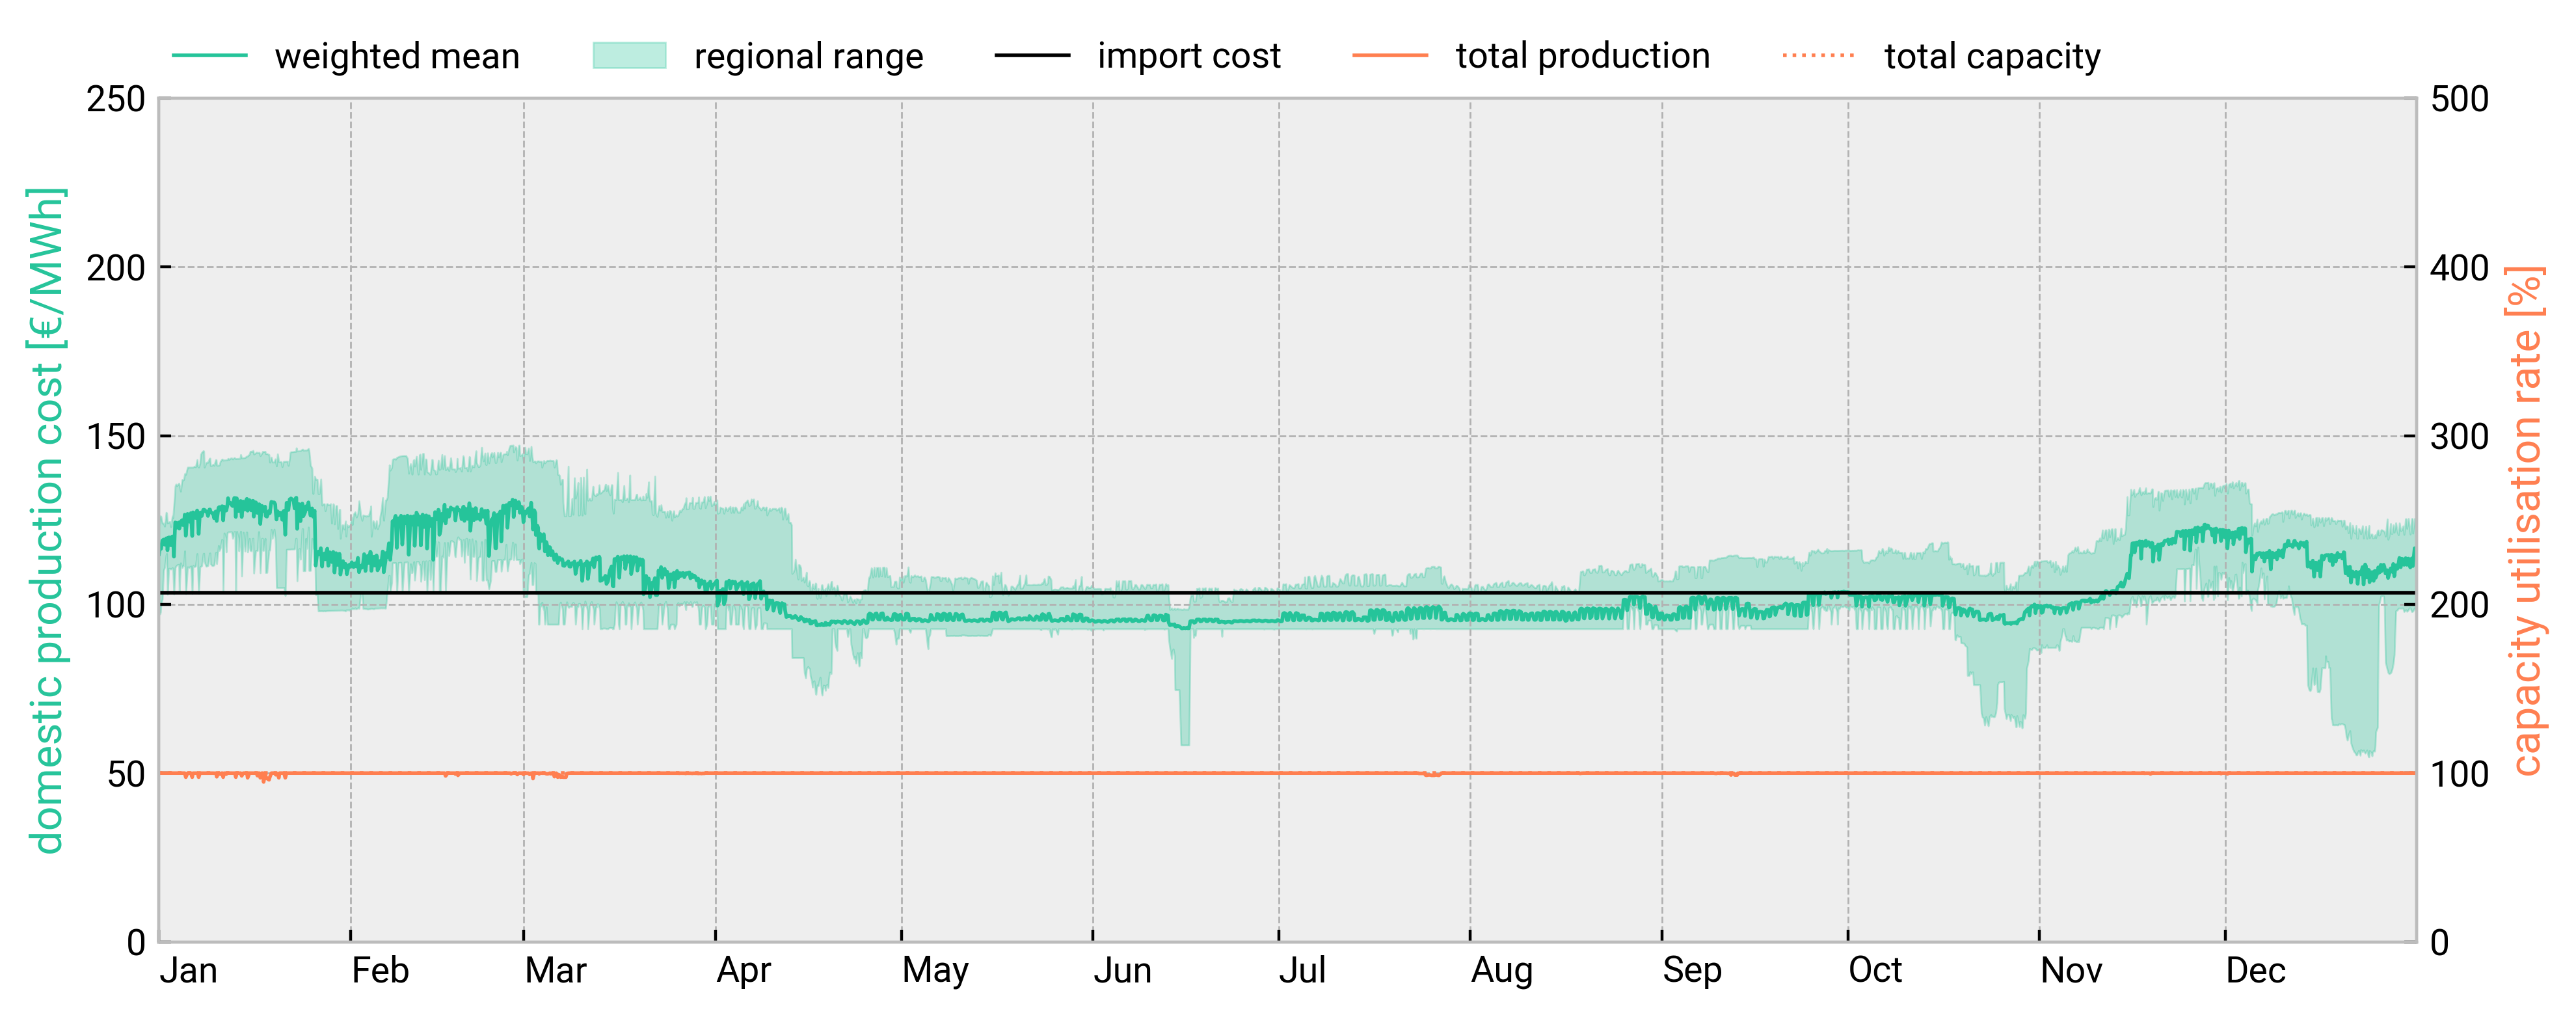

In [706]:
mean_values = (ft_cost_t * ft_oil_output).sum(axis=1) / ft_oil_output.sum()
min_values = ft_cost_t.min(axis=1)
max_values = ft_cost_t.max(axis=1)

fig, ax = plt.subplots(figsize=(10, 4))

mean_values.plot(ax=ax, label="weighted mean", color=tech_colors["Fischer-Tropsch"], linewidth=1)
plt.fill_between(ft_cost_t.index, min_values, max_values, color=tech_colors["Fischer-Tropsch"], alpha=0.3, label='regional range')

ax.axhline(min_import_costs.at["Fischer-Tropsch", "min"], color="black", lw=1, label="import cost")


ax_twin = ax.twinx()

total_capacity = ft.eval("p_nom_opt * efficiency").sum()

ft_oil.sum(axis=1).div(total_capacity).mul(100).plot(ax=ax_twin, linewidth=1, color="coral", label="total production")

ax_twin.axhline(100, lw=1, label="total capacity", linestyle=":", color='coral')

ax_twin.grid(False)

ax_twin.set_ylim(0, 500)

ax_twin.set_ylabel("capacity utilisation rate [%]", color="coral")


import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
for label in ax.get_xticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment('left')

ax.set_ylim(0, 250)

ax.set_ylabel('domestic production cost [€/MWh]', color=tech_colors["Fischer-Tropsch"])
ax.set_xlabel("")
ax.set_xlim("2013-01-01 00:00", "2013-12-31 23:00");

handles, labels = [], []
for ax in [ax, ax_twin]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Create a single combined legend
plt.legend(handles, labels, ncol=5, loc=(0, 1.01))

plt.savefig(f"ft-t-{scenario_name}.png")

In [707]:
# end time series

In [708]:
ft_co2_cost = weights @ ft_co2.mul(co2_prices - co2_tax, axis=0)
ft_h2_cost = weights @ (h2_prices[ft.index] * ft_h2)
ft_oil_revenue = weights @ (ft_oil.mul(oil_prices, axis=0) - ft_co2.mul(co2_tax, axis=0))
ft_heat_revenue = weights @ (heat_prices[ft.index] * ft_heat)

In [709]:
ft_cost = (ft_co2_cost + ft_h2_cost + ft_capex - ft_heat_revenue) / ft_oil_output

In [710]:
ft_revenue = ft_oil_revenue / ft_oil_output

In [711]:
ft_balance = pd.DataFrame({
    "hydrogen cost": ft_h2_cost,
    "CO2 cost": ft_co2_cost,
    "investment cost": ft_capex,
    "heat revenue": -ft_heat_revenue,
    "product revenue": -ft_oil_revenue
}).div(ft_oil_output, axis=0)

ft_balance = pd.Series(
    np.average(ft_balance, weights=ft_oil_output, axis=0),
    index=ft_balance.columns
)
ft_balance

hydrogen cost       74.814291
CO2 cost            24.924991
investment cost      9.245840
heat revenue        -5.489977
product revenue   -103.507558
dtype: float64

## Breakdown methanol market value

In [712]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "methanolisation"
threshold = 1
weights = n.snapshot_weightings.generators

In [713]:
meoh = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(index=mapper)

In [714]:
meoh_capex = meoh.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [715]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
meoh_h2 = n.links_t.p0.loc[:, sel].rename(columns=mapper)
meoh_meoh = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
meoh_ac = n.links_t.p2.loc[:, sel].rename(columns=mapper)
meoh_co2 = n.links_t.p3.loc[:, sel].rename(columns=mapper)
meoh_heat = -n.links_t.p4.loc[:, sel].rename(columns=mapper)

In [716]:
meoh_meoh_output = weights @ meoh_meoh

In [717]:
## start time series

In [718]:
meoh_ac_cost_t = (ac_prices[meoh.index] * meoh_ac) / meoh_meoh
meoh_co2_cost_t = meoh_co2.mul(co2_prices - co2_tax, axis=0) / meoh_meoh
meoh_h2_cost_t = (h2_prices[meoh.index] * meoh_h2) / meoh_meoh
meoh_meoh_revenue_t = (meoh_meoh.mul(oil_prices, axis=0) - meoh_co2.mul(co2_tax, axis=0)) / meoh_meoh
meoh_heat_revenue_t = (heat_prices[meoh.index] * meoh_heat) / meoh_meoh
meoh_capex_t = (meoh_capex * meoh_meoh.mul(weights, axis=0).div(meoh_meoh_output)) / meoh_meoh_output

In [719]:
meoh_cost_t = (meoh_co2_cost_t + meoh_h2_cost_t + meoh_ac_cost_t + meoh_heat_revenue_t + meoh_capex_t)

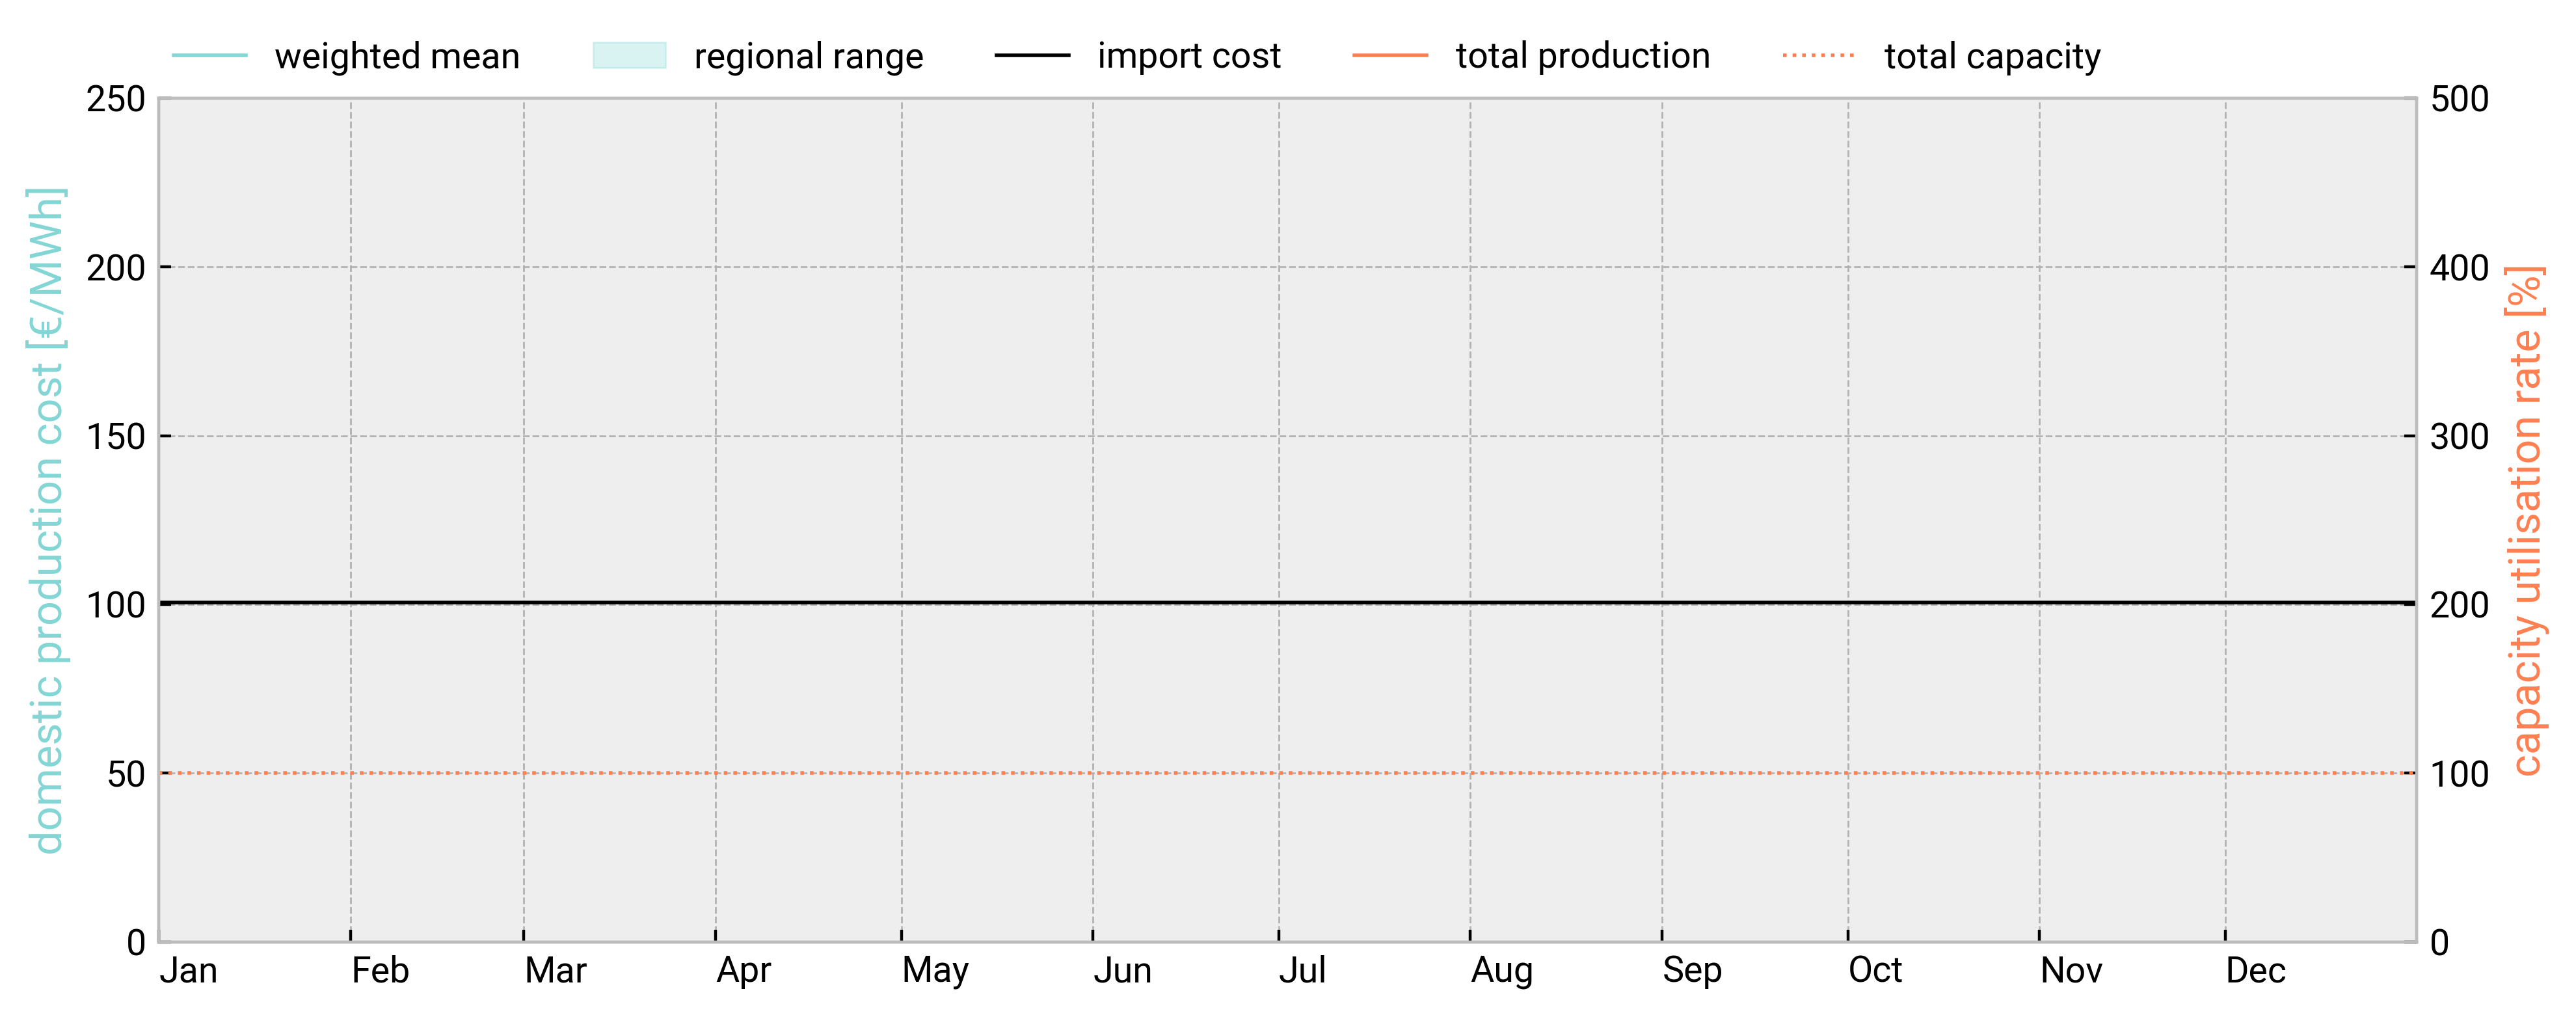

In [720]:
mean_values = (meoh_cost_t * meoh_meoh_output).sum(axis=1) / meoh_meoh_output.sum()
min_values = meoh_cost_t.min(axis=1)
max_values = meoh_cost_t.max(axis=1)

fig, ax = plt.subplots(figsize=(10, 4))

mean_values.plot(ax=ax, label="weighted mean", color=tech_colors["methanolisation"], linewidth=1)
plt.fill_between(meoh_cost_t.index, min_values, max_values, color=tech_colors["methanolisation"], alpha=0.3, label='regional range')

ax.axhline(min_import_costs.at["methanol", "min"], color="black", lw=1, label="import cost")


ax_twin = ax.twinx()

total_capacity = meoh.eval("p_nom_opt * efficiency").sum()

meoh_meoh.sum(axis=1).div(total_capacity).mul(100).plot(ax=ax_twin, linewidth=1, color="coral", label="total production")

ax_twin.axhline(100, lw=1, label="total capacity", linestyle=":", color='coral')

ax_twin.grid(False)

ax_twin.set_ylim(0, 500)

ax_twin.set_ylabel("capacity utilisation rate [%]", color="coral")


import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
for label in ax.get_xticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment('left')

ax.set_ylim(0, 250)

ax.set_ylabel('domestic production cost [€/MWh]', color=tech_colors["methanolisation"])
ax.set_xlabel("")
ax.set_xlim("2013-01-01 00:00", "2013-12-31 23:00");

handles, labels = [], []
for ax in [ax, ax_twin]:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Create a single combined legend
plt.legend(handles, labels, ncol=5, loc=(0, 1.01))


plt.savefig(f"meoh-t-{scenario_name}.png")

In [721]:
# end time series

In [722]:
meoh_co2_cost = weights @ meoh_co2.mul(co2_prices - co2_tax, axis=0)
meoh_h2_cost = weights @ (h2_prices[meoh.index] * meoh_h2)
meoh_ac_cost = weights @ (ac_prices[meoh.index] * meoh_ac)
meoh_meoh_revenue = weights @ (meoh_meoh.mul(meoh_prices, axis=0) - meoh_co2.mul(co2_tax, axis=0))
meoh_heat_revenue = weights @ (heat_prices[meoh.index] * meoh_heat)

In [723]:
meoh_cost = (meoh_co2_cost + meoh_h2_cost + meoh_ac_cost + meoh_capex - meoh_heat_revenue) / meoh_meoh_output

In [724]:
meoh_revenue = meoh_meoh_revenue / meoh_meoh_output

In [725]:
meoh_balance = pd.DataFrame({
    "electricity cost": meoh_ac_cost,
    "hydrogen cost": meoh_h2_cost,
    "CO2 cost": meoh_co2_cost,
    "investment cost": meoh_capex,
    "heat revenue": -meoh_heat_revenue,
    "product revenue": -meoh_meoh_revenue
}).div(meoh_meoh_output, axis=0)

meoh_balance = pd.Series(
    np.average(meoh_balance, weights=meoh_meoh_output, axis=0),
    index=meoh_balance.columns
)
meoh_balance

ZeroDivisionError: Weights sum to zero, can't be normalized

## Breakdown steel market value

In [726]:
mapper = n.links.bus0.map(n.buses.location)
carrier = "DRI + Electric arc"
threshold = 1
weights = n.snapshot_weightings.generators

In [727]:
drieaf = n.links.query("carrier == @carrier and p_nom_opt > @threshold").rename(index=mapper)

In [728]:
drieaf_capex = drieaf.eval("p_nom_opt * capital_cost").rename(index=mapper)

In [729]:
sel = (n.links.carrier == carrier) & (n.links.p_nom_opt > threshold)
drieaf_ac = n.links_t.p0.loc[:, sel].rename(columns=mapper)
drieaf_steel = -n.links_t.p1.loc[:, sel].rename(columns=mapper)
drieaf_h2 = n.links_t.p2.loc[:, sel].rename(columns=mapper)

In [730]:
drieaf_steel_output = weights @ drieaf_steel

In [731]:
drieaf_h2_cost = weights @ (h2_prices[drieaf.index] * drieaf_h2)
drieaf_ac_cost = weights @ (ac_prices[drieaf.index] * drieaf_ac)
drieaf_ore_cost = weights @ (drieaf.marginal_cost * drieaf_ac) # since AC is bus0
drieaf_steel_revenue =  weights @ drieaf_steel.mul(steel_prices, axis=0)

In [732]:
drieaf_cost = (drieaf_h2_cost + drieaf_ac_cost + drieaf_ore_cost + drieaf_capex) / drieaf_steel_output

In [733]:
drieaf_revenue = drieaf_steel_revenue / drieaf_steel_output

In [734]:
drieaf_balance = pd.DataFrame({
    "electricity cost": drieaf_ac_cost,
    "hydrogen cost": drieaf_h2_cost,
    "iron ore": drieaf_ore_cost,
    "investment cost": drieaf_capex,
    "product revenue": -drieaf_steel_revenue
}).div(drieaf_steel_output, axis=0)

drieaf_balance = pd.Series(
    np.average(drieaf_balance, weights=drieaf_steel_output, axis=0),
    index=drieaf_balance.columns
)
drieaf_balance

ZeroDivisionError: Weights sum to zero, can't be normalized

In [735]:
colors = {
    "electricity cost": '#97ad8c',
    "hydrogen cost": "#ebaee0",
    "investment cost":  '#bdd8d3',
    "heat revenue": '#ff7c7c',
    "iron ore": tech_colors["steel"],
    "CO2 cost": tech_colors["co2"],
}

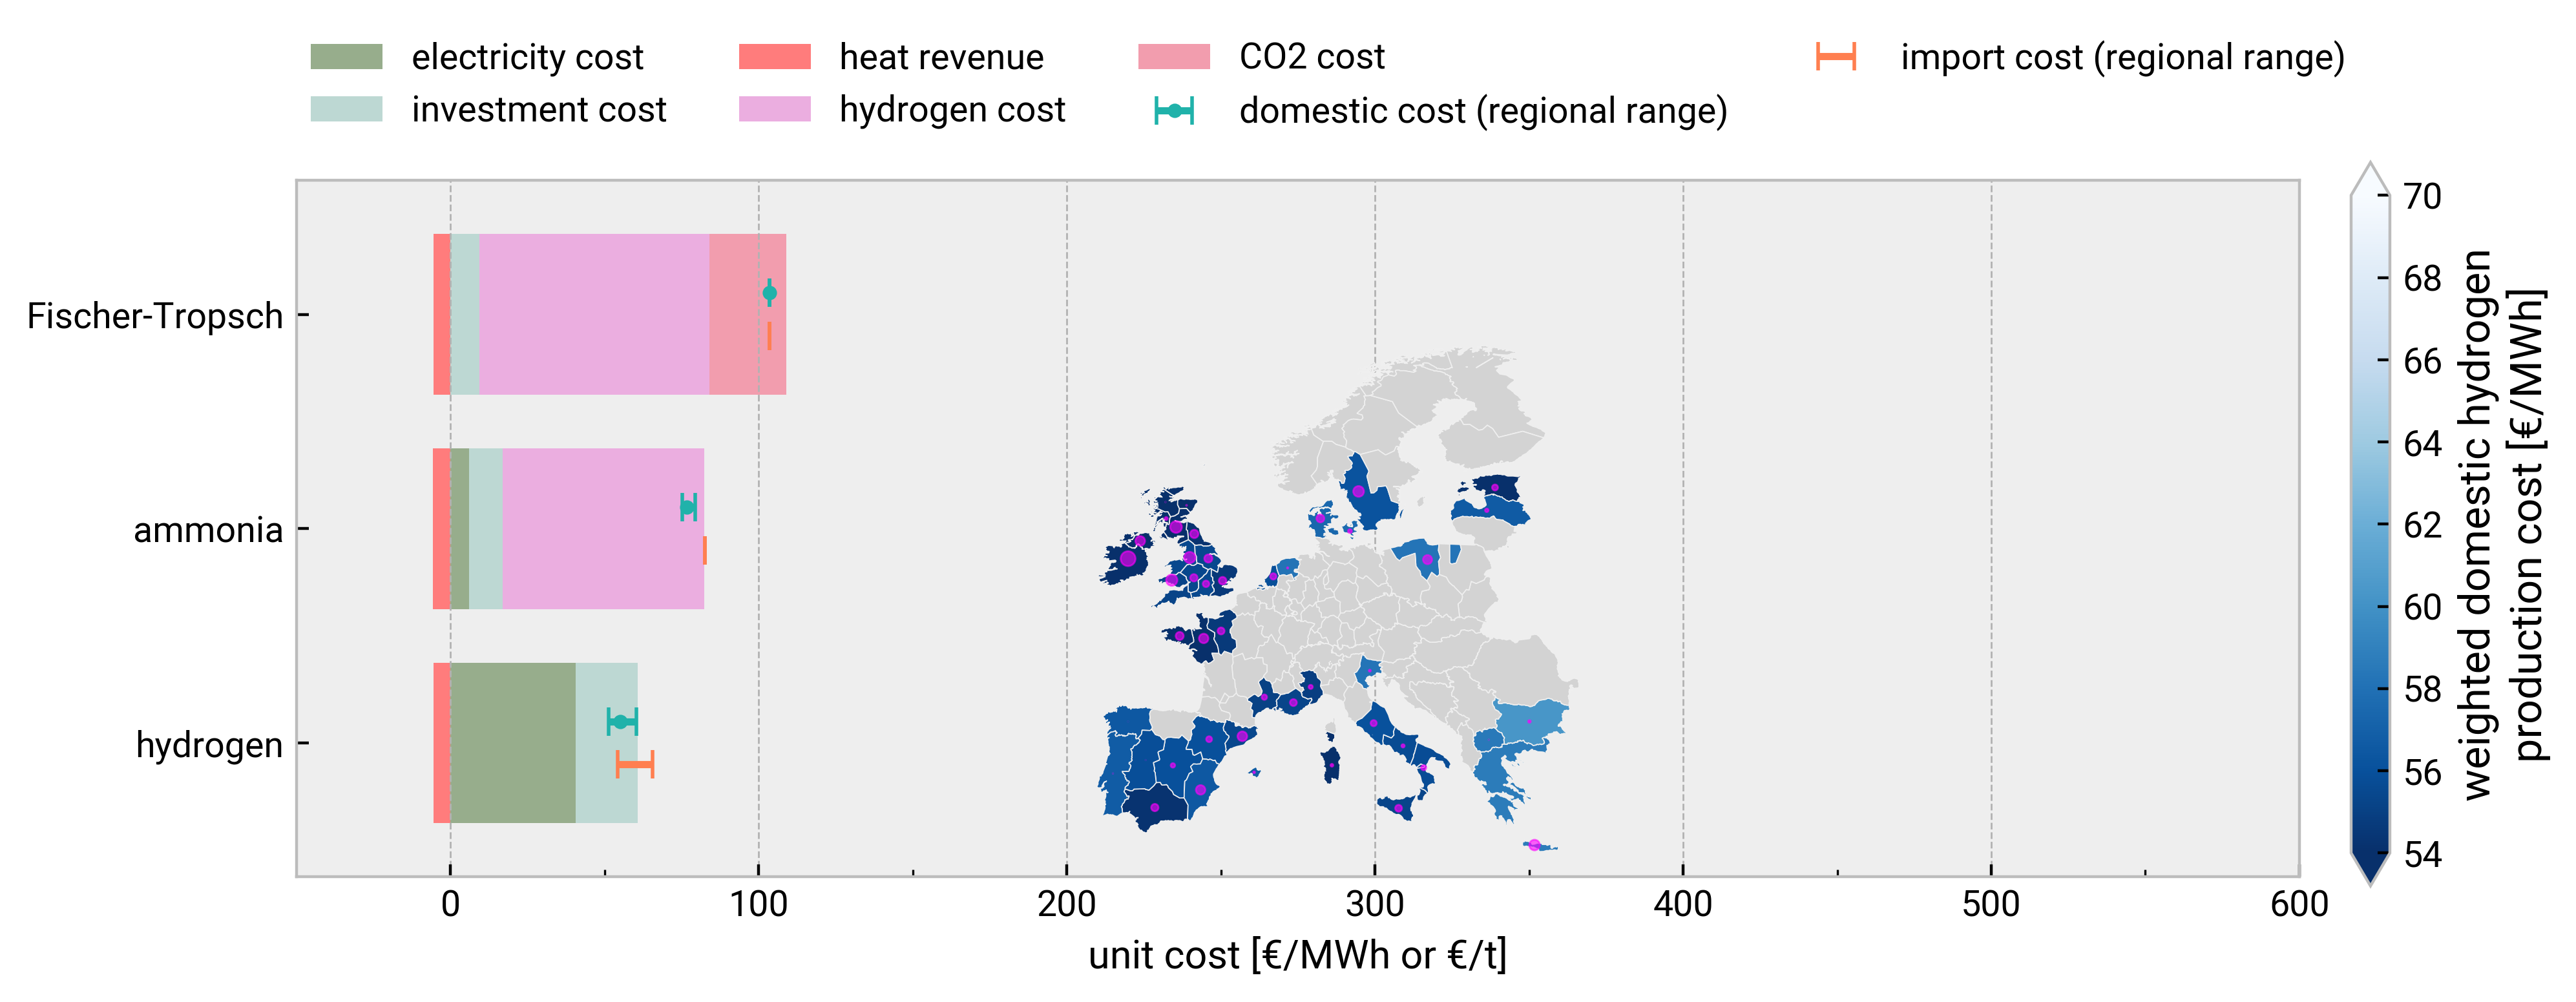

In [736]:
fig, ax = plt.subplots(figsize=(10, 3.5))

fig.set_tight_layout(False)

composition = pd.concat({
    "hydrogen": electrolysers_balance,
    "ammonia": haberbosch_balance,
    "Fischer-Tropsch": ft_balance,
    #"methanol": meoh_balance,
    #"steel": drieaf_balance,
}, axis=1).drop("product revenue")

costs = composition.sum()

composition.T.plot.barh(ax=ax, stacked=True, width=0.75, color=colors)

errors = pd.concat({
    "hydrogen": electrolysers_cost,
    "ammonia": haberbosch_cost,
    "Fischer-Tropsch": ft_cost,
    #"methanol": meoh_cost,
    #"steel": drieaf_cost,
}, axis=1).describe().loc[["min", "max"]].sub(costs).T.abs()

from matplotlib.transforms import Affine2D
trans1 = Affine2D().translate(0.0, 0.1) + ax.transData
trans2 = Affine2D().translate(0.0, -0.1) + ax.transData

ax.errorbar(
    costs,
    composition.columns,
    xerr=errors.T.values,
    fmt='.',
    capsize=4,
    color='lightseagreen',
    transform=trans1,
    label="domestic cost (regional range)"
)

imports = min_import_costs.reindex_like(errors)

ax.errorbar(
    imports.min(axis=1),
    composition.columns,
    xerr=(imports.T - imports.min(axis=1)).values,
    fmt='None',
    capsize=4,
    color='coral',
    transform=trans2,
    label="import cost (regional range)"
)

plt.xlim(-50, 600)
plt.grid(axis="y")
plt.xlabel("unit cost [€/MWh or €/t]", fontsize=11)

plt.legend(ncol=4, loc=(0,1.05))

plt.xticks(range(50, 600, 100), minor=True);

ax_inset = ax.inset_axes([0.12, 0, 0.8, 0.8])

regions_fn = "/home/fneum/bwss/papers/import-benefits/workflow/pypsa-eur/resources/20231025-zecm/regions_onshore_elec_s_110.geojson"
crs = ccrs.EqualEarth()
regions = gpd.read_file(regions_fn).set_index("name").to_crs(crs.proj4_init)
#fig, ax_inset = plt.subplots(figsize=(7,7), subplot_kw=dict(projection=crs))

left, bottom, width, height = [0.92, 0.1, 0.015, 0.8]
ax_cbar = fig.add_axes([left, bottom, width, height])
ax_cbar.grid(False)

regions_plot = regions.plot(
    ax=ax_inset,
    cmap="Blues_r",
    column=electrolysers_cost.reindex(regions.index),
    missing_kwds=dict(color="lightgrey", label="no electrolysers"),
    linewidth=.3,
    edgecolor="#efefef",
    cax=ax_cbar,
    vmin=54,
    vmax=70,
    legend=True,
    legend_kwds={
        "label": "weighted domestic hydrogen\nproduction cost [€/MWh]",
        "shrink": 0.9,
        "extend": "both",
        "pad": 0,
        "aspect": 35,
    },
)

regions.representative_point().plot(
    ax=ax_inset,
    markersize=electrolysers_h2_output.reindex(regions.index) / 3e6,
    color='magenta',
    alpha=0.6,
)

ax_inset.axis('off')
ax_inset.set_facecolor('none')

plt.savefig(f"bars-{scenario_name}.png")